In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

In [3]:
df_new = pd.read_csv('Processed_Fatality_2022_2023_FE.csv')

In [4]:
# Prepare modeling data
df_model = df_new.dropna(subset=['delay_smart_bin'])

# Separate target and features
y = df_model['delay_smart_bin']
X = df_model.drop(['delay_hours', 'time_notified', 
                   'datetime_crash', 'datetime_not_crash', 
                   'date_crash','LATITUDE','LONGITUD',
                   'HOSP_HR','HOSP_MN',
                   'TWAY_ID2','OBJECTID',
                   'ST_CASE','FATALS','PEDS','PERSONS',
                   'PERNOTMVIT','PERMVIT','VE_TOTAL','VE_FORMS',
                   'PVH_INVL','x','y','HARM_EV',
                   "tm_crash","not_tm_crash",
                   "HOSP_HRNAME","HOSP_MNNAME",
                   "RAILNAME","SCH_BUSNAME",
                   "MAN_COLLNAME","HARM_EVNAME",'WRK_ZONENAME',
                   "MAN_COLL","LATITUDENAME","LONGITUDNAME",
                   "MINUTENAME","DAYNAME","YEAR","MINUTE","STATENAME","delay_minutes","delay_min_bin","delay_bin",
                   "delay_stat_bin","delay_adaptive_bin",
                   "delay_smart_bin","narrative_bin",
                   "delay_quantile_bin",
                   "survivor_category",
                   "people_not_dead","HOURNAME","HOUR",
                   "MILEPTNAME","MILEPT",
                   ], axis=1)


In [5]:
# Find columns that have both 'COLNAME' and 'COL' versions (where we want to keep 'COLNAME' and exclude 'COL')
cols_with_name_suffix = [col for col in X.columns if col.endswith('NAME')]
base_cols_to_exclude = []

for col_with_name in cols_with_name_suffix:
    # Remove 'NAME' suffix to get the base column name
    base_col = col_with_name[:-4]  # Remove last 4 characters ('NAME')
    
    # Check if the base column exists in the dataframe
    if base_col in X.columns:
        base_cols_to_exclude.append(base_col)
        print(f"Found pair: {base_col} and {col_with_name} - excluding {base_col}")

# Exclude columns that start with 'NOT' or 'ARR'
cols_to_exclude_start = [col for col in X.columns if col.startswith('NOT') or col.startswith('ARR')]

# Combine all columns to exclude
cols_to_exclude = list(set(cols_to_exclude_start + base_cols_to_exclude))

print(f"\nAll columns to exclude: {cols_to_exclude}")


Found pair: COUNTY and COUNTYNAME - excluding COUNTY
Found pair: CITY and CITYNAME - excluding CITY
Found pair: MONTH and MONTHNAME - excluding MONTH
Found pair: DAY_WEEK and DAY_WEEKNAME - excluding DAY_WEEK
Found pair: ROUTE and ROUTENAME - excluding ROUTE
Found pair: RUR_URB and RUR_URBNAME - excluding RUR_URB
Found pair: FUNC_SYS and FUNC_SYSNAME - excluding FUNC_SYS
Found pair: RD_OWNER and RD_OWNERNAME - excluding RD_OWNER
Found pair: NHS and NHSNAME - excluding NHS
Found pair: SP_JUR and SP_JURNAME - excluding SP_JUR
Found pair: RELJCT1 and RELJCT1NAME - excluding RELJCT1
Found pair: RELJCT2 and RELJCT2NAME - excluding RELJCT2
Found pair: TYP_INT and TYP_INTNAME - excluding TYP_INT
Found pair: REL_ROAD and REL_ROADNAME - excluding REL_ROAD
Found pair: LGT_COND and LGT_CONDNAME - excluding LGT_COND
Found pair: WEATHER and WEATHERNAME - excluding WEATHER
Found pair: NOT_HOUR and NOT_HOURNAME - excluding NOT_HOUR
Found pair: NOT_MIN and NOT_MINNAME - excluding NOT_MIN
Found pair: A

In [6]:
# Drop the excluded columns that exist in the DataFrame
X = X.drop(columns=[col for col in cols_to_exclude if col in X.columns])

In [7]:
X.shape

(29875, 23)

In [8]:
categorical_cols = X.select_dtypes(include=['object']).columns
categorical_cols

Index(['COUNTYNAME', 'CITYNAME', 'MONTHNAME', 'DAY_WEEKNAME', 'TWAY_ID',
       'ROUTENAME', 'RUR_URBNAME', 'FUNC_SYSNAME', 'RD_OWNERNAME', 'NHSNAME',
       'SP_JURNAME', 'RELJCT1NAME', 'RELJCT2NAME', 'TYP_INTNAME',
       'REL_ROADNAME', 'LGT_CONDNAME', 'WEATHERNAME', 'RAIL', 'time_period'],
      dtype='object')

In [9]:
encoder = ce.TargetEncoder(cols=categorical_cols)
X = encoder.fit_transform(X, y)
X.shape

(29875, 23)

In [11]:
# Check the target variable distribution
print("Target Variable Distribution:")
print(y.value_counts())
print(f"\nTarget variable shape: {y.shape}")
print(f"Features shape: {X.shape}")
print(f"Number of classes: {y.nunique()}")
print(f"Class labels: {sorted(y.unique())}")

Target Variable Distribution:
delay_smart_bin
0-5 min\n(Excellent)       23501
5-15 min\n(Good)            4522
15-30 min\n(Acceptable)      915
60+ min\n(Critical)          536
30-60 min\n(Delayed)         401
Name: count, dtype: int64

Target variable shape: (29875,)
Features shape: (29875, 23)
Number of classes: 5
Class labels: ['0-5 min\n(Excellent)', '15-30 min\n(Acceptable)', '30-60 min\n(Delayed)', '5-15 min\n(Good)', '60+ min\n(Critical)']


In [12]:
# Import classification libraries
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Training target distribution:")
print(y_train.value_counts())
print(f"\nTest target distribution:")
print(y_test.value_counts())

Training set size: (23900, 23)
Test set size: (5975, 23)
Training target distribution:
delay_smart_bin
0-5 min\n(Excellent)       18801
5-15 min\n(Good)            3617
15-30 min\n(Acceptable)      732
60+ min\n(Critical)          429
30-60 min\n(Delayed)         321
Name: count, dtype: int64

Test target distribution:
delay_smart_bin
0-5 min\n(Excellent)       4700
5-15 min\n(Good)            905
15-30 min\n(Acceptable)     183
60+ min\n(Critical)         107
30-60 min\n(Delayed)         80
Name: count, dtype: int64


In [13]:
# ===============================================
# CLASSIFICATION MODELS
# ===============================================

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True)
}

# Store results
results = {}

print("🤖 TRAINING CLASSIFICATION MODELS")
print("="*50)

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"✅ {name} completed")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall: {recall:.4f}")
    print(f"   F1-Score: {f1:.4f}")

print(f"\n🎯 All models trained successfully!")

🤖 TRAINING CLASSIFICATION MODELS

Training Random Forest...
✅ Random Forest completed
   Accuracy: 0.8603
   Precision: 0.8463
   Recall: 0.8603
   F1-Score: 0.8380

Training Gradient Boosting...
✅ Gradient Boosting completed
   Accuracy: 0.8849
   Precision: 0.8815
   Recall: 0.8849
   F1-Score: 0.8747

Training Logistic Regression...
✅ Logistic Regression completed
   Accuracy: 0.8328
   Precision: 0.7845
   Recall: 0.8328
   F1-Score: 0.8004

Training SVM...
✅ SVM completed
   Accuracy: 0.7866
   Precision: 0.6188
   Recall: 0.7866
   F1-Score: 0.6927

🎯 All models trained successfully!


📊 MODEL PERFORMANCE COMPARISON
              Model  Accuracy  Precision  Recall  F1-Score
      Random Forest    0.8603     0.8463  0.8603    0.8380
  Gradient Boosting    0.8849     0.8815  0.8849    0.8747
Logistic Regression    0.8328     0.7845  0.8328    0.8004
                SVM    0.7866     0.6188  0.7866    0.6927

🏆 Best performing model: Gradient Boosting
   Accuracy: 0.8849


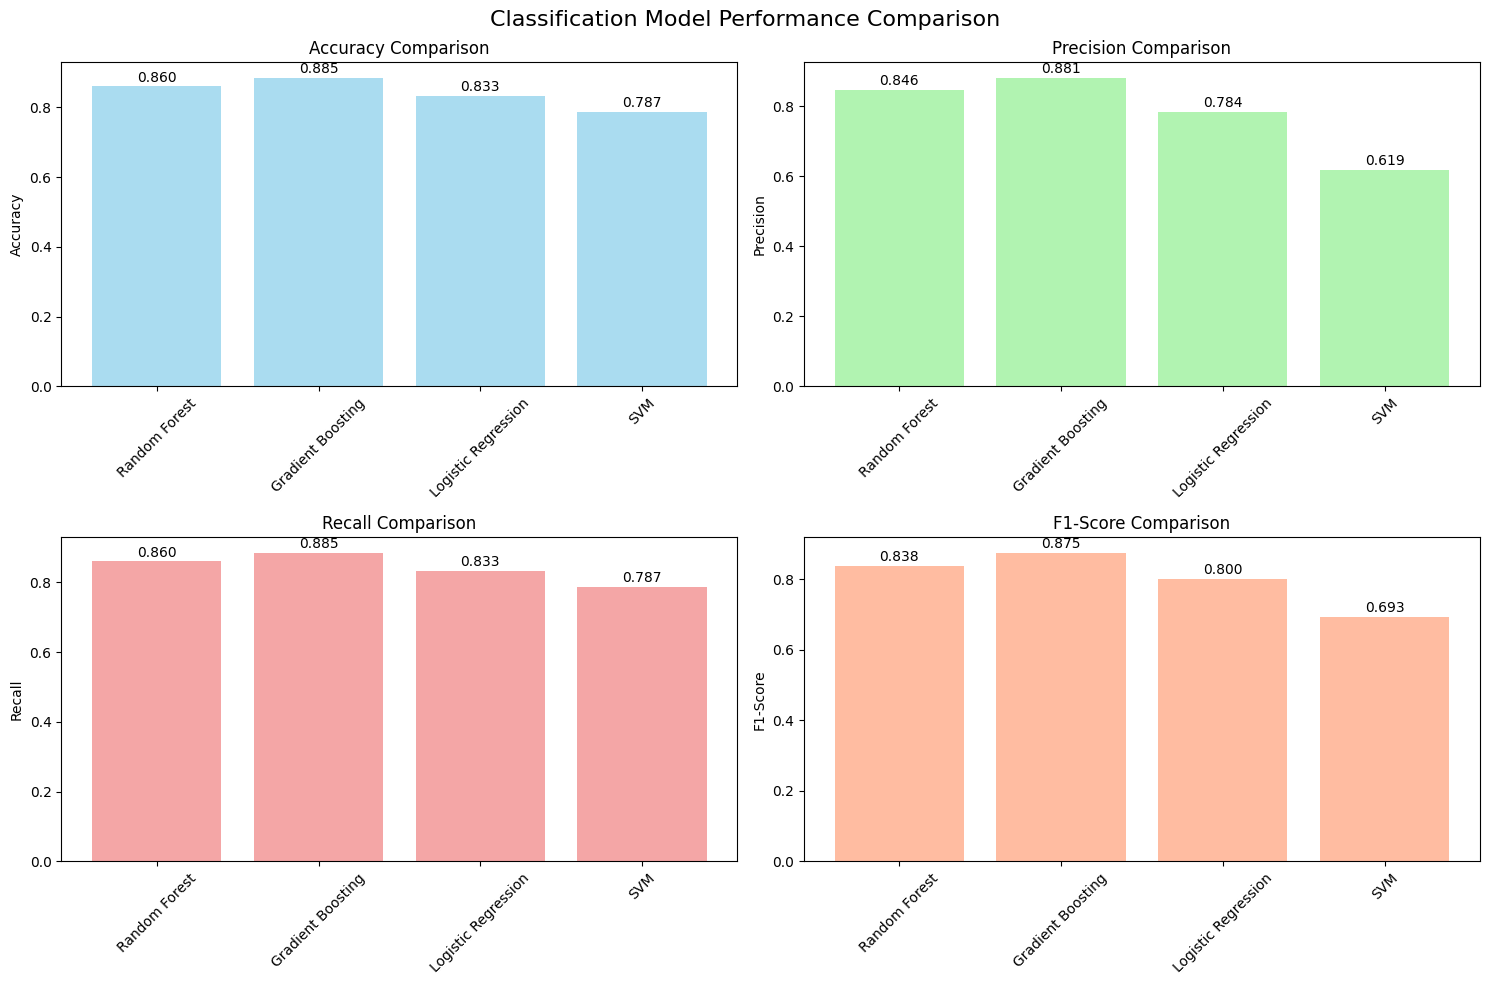

In [15]:
# ===============================================
# MODEL COMPARISON
# ===============================================

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results.keys()],
    'Precision': [results[model]['precision'] for model in results.keys()],
    'Recall': [results[model]['recall'] for model in results.keys()],
    'F1-Score': [results[model]['f1_score'] for model in results.keys()]
})

print("📊 MODEL PERFORMANCE COMPARISON")
print("="*40)
print(comparison_df.round(4).to_string(index=False))

# Find best model
best_model_name = comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Model']
print(f"\n🏆 Best performing model: {best_model_name}")
print(f"   Accuracy: {comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Accuracy']:.4f}")

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Classification Model Performance Comparison', fontsize=16)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon']

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], color=colors[i], alpha=0.7)
    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

🔍 DETAILED EVALUATION: Gradient Boosting

📋 CLASSIFICATION REPORT:
------------------------------
                        precision    recall  f1-score   support

   0-5 min
(Excellent)       0.90      0.98      0.93      4700
15-30 min
(Acceptable)       0.95      0.48      0.63       183
   30-60 min
(Delayed)       0.93      0.50      0.65        80
       5-15 min
(Good)       0.79      0.57      0.66       905
    60+ min
(Critical)       0.91      0.50      0.64       107

              accuracy                           0.88      5975
             macro avg       0.89      0.60      0.70      5975
          weighted avg       0.88      0.88      0.87      5975


🔄 CONFUSION MATRIX:
--------------------
[[4593    3    3  101    0]
 [  80   87    0   14    2]
 [  33    0   40    7    0]
 [ 387    1    0  514    3]
 [  37    1    0   16   53]]


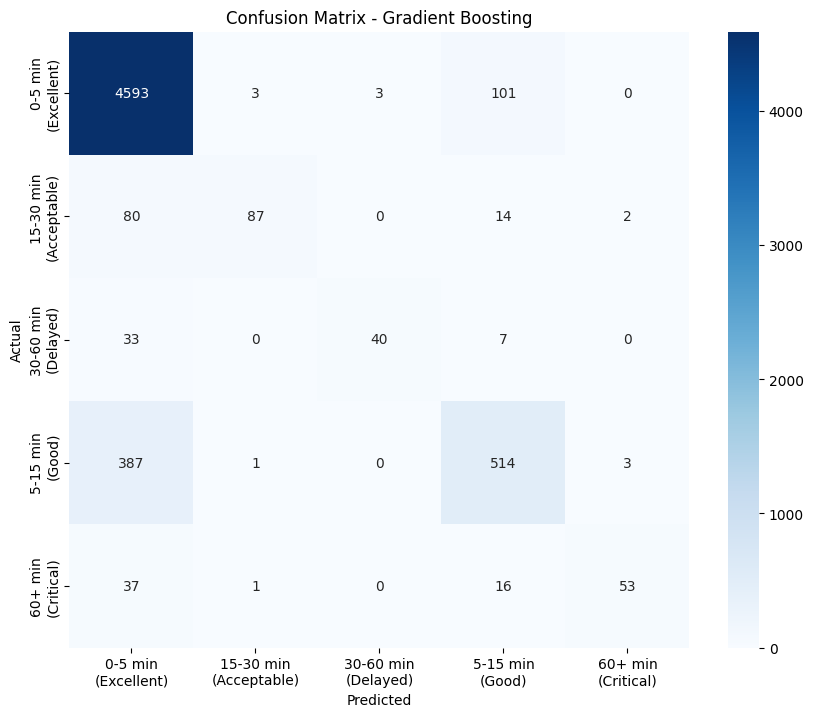


🎯 TOP 10 FEATURE IMPORTANCES:
-----------------------------------
     feature  importance
     TWAY_ID    0.815617
    CITYNAME    0.089784
  COUNTYNAME    0.060463
RD_OWNERNAME    0.004856
 RUR_URBNAME    0.004656
       STATE    0.003700
 time_period    0.003034
         DAY    0.002333
REL_ROADNAME    0.002222
 WEATHERNAME    0.002056


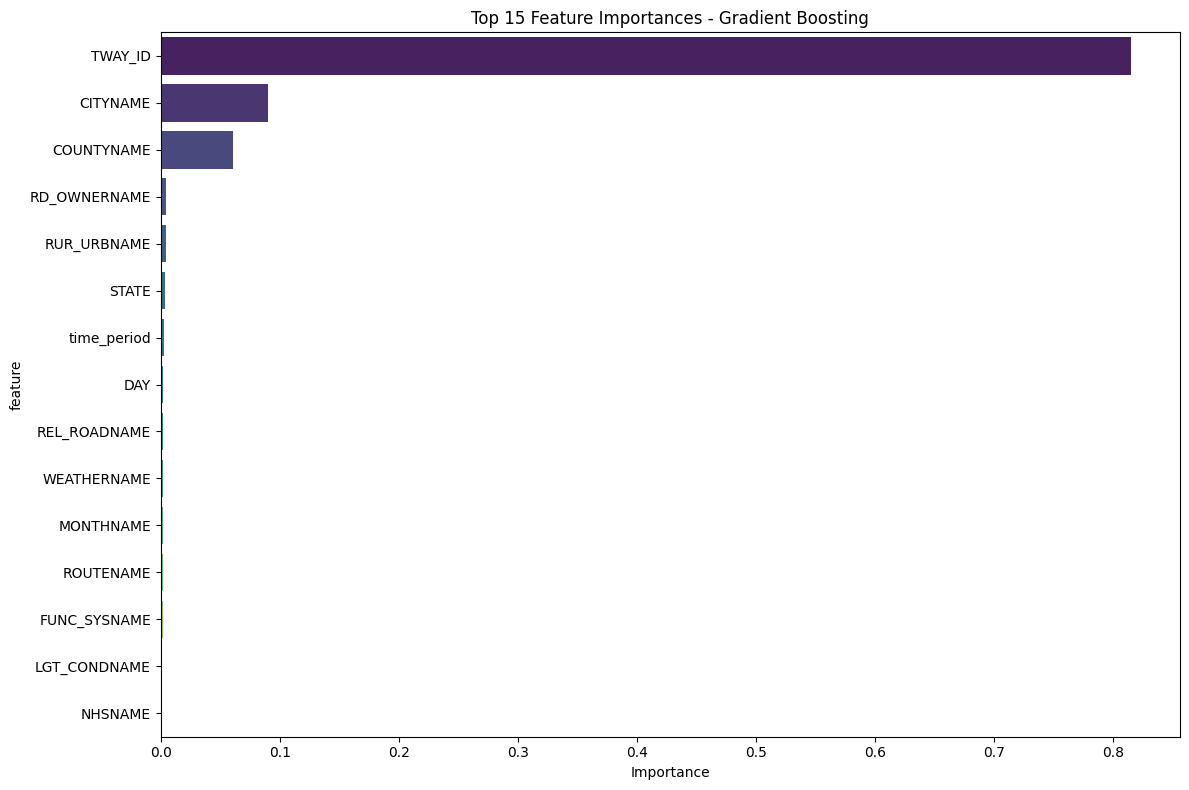


✅ Classification model evaluation complete!
Best model (Gradient Boosting) achieved 0.8849 accuracy


In [17]:
# ===============================================
# DETAILED EVALUATION OF BEST MODEL
# ===============================================

best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']

print(f"🔍 DETAILED EVALUATION: {best_model_name}")
print("="*50)

# Classification Report
print("\n📋 CLASSIFICATION REPORT:")
print("-" * 30)
print(classification_report(y_test, best_predictions))

# Confusion Matrix
print("\n🔄 CONFUSION MATRIX:")
print("-" * 20)
cm = confusion_matrix(y_test, best_predictions)
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y.unique()), 
            yticklabels=sorted(y.unique()))
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance (if available)
if hasattr(best_model, 'feature_importances_'):
    print(f"\n🎯 TOP 10 FEATURE IMPORTANCES:")
    print("-" * 35)
    
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(feature_importance.head(10).to_string(index=False))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
    plt.title(f'Top 15 Feature Importances - {best_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

print(f"\n✅ Classification model evaluation complete!")
print(f"Best model ({best_model_name}) achieved {results[best_model_name]['accuracy']:.4f} accuracy")

In [18]:
# ===============================================
# SAVE BEST MODEL
# ===============================================

import pickle

# Save the best classification model
model_filename = f'{best_model_name.lower().replace(" ", "_")}_classification_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

# Save the encoder
encoder_filename = 'target_encoder_classification.pkl'
with open(encoder_filename, 'wb') as file:
    pickle.dump(encoder, file)

# Save model metadata
metadata = {
    'model_name': best_model_name,
    'model_type': 'classification',
    'target_variable': 'delay_smart_bin',
    'features_used': list(X.columns),
    'performance_metrics': {
        'accuracy': results[best_model_name]['accuracy'],
        'precision': results[best_model_name]['precision'],
        'recall': results[best_model_name]['recall'],
        'f1_score': results[best_model_name]['f1_score']
    },
    'train_size': len(X_train),
    'test_size': len(X_test),
    'n_classes': y.nunique(),
    'class_labels': sorted(y.unique())
}

metadata_filename = 'classification_model_metadata.pkl'
with open(metadata_filename, 'wb') as file:
    pickle.dump(metadata, file)

print(f"💾 MODEL SAVED SUCCESSFULLY!")
print("="*30)
print(f"Model file: {model_filename}")
print(f"Encoder file: {encoder_filename}")
print(f"Metadata file: {metadata_filename}")
print(f"\nBest model: {best_model_name}")
print(f"Final accuracy: {results[best_model_name]['accuracy']:.4f}")

# Summary of all models
print(f"\n📈 FINAL SUMMARY - ALL MODELS:")
print("="*40)
for model_name in results.keys():
    print(f"{model_name:<20}: {results[model_name]['accuracy']:.4f} accuracy")

print(f"\n🎉 Classification pipeline complete!")

💾 MODEL SAVED SUCCESSFULLY!
Model file: gradient_boosting_classification_model.pkl
Encoder file: target_encoder_classification.pkl
Metadata file: classification_model_metadata.pkl

Best model: Gradient Boosting
Final accuracy: 0.8849

📈 FINAL SUMMARY - ALL MODELS:
Random Forest       : 0.8603 accuracy
Gradient Boosting   : 0.8849 accuracy
Logistic Regression : 0.8328 accuracy
SVM                 : 0.7866 accuracy

🎉 Classification pipeline complete!


In [24]:
# ===============================================
# LOAD AND INFERENCE WITH BEST MODEL
# ===============================================

import pickle
import pandas as pd
import numpy as np

print("🔄 LOADING SAVED MODEL FOR INFERENCE")
print("="*45)

# Load model metadata to understand what was saved
try:
    with open('classification_model_metadata.pkl', 'rb') as file:
        metadata = pickle.load(file)
    
    print("📋 MODEL METADATA:")
    print("-" * 20)
    print(f"Model Name: {metadata['model_name']}")
    print(f"Model Type: {metadata['model_type']}")
    print(f"Target Variable: {metadata['target_variable']}")
    print(f"Number of Features: {len(metadata['features_used'])}")
    print(f"Number of Classes: {metadata['n_classes']}")
    print(f"Class Labels: {metadata['class_labels']}")
    print(f"Training Accuracy: {metadata['performance_metrics']['accuracy']:.4f}")
    print(f"Training Size: {metadata['train_size']:,}")
    print(f"Test Size: {metadata['test_size']:,}")
    
except FileNotFoundError:
    print("❌ Metadata file not found. Please run the model training first.")
    
print("\n" + "="*45)

🔄 LOADING SAVED MODEL FOR INFERENCE
📋 MODEL METADATA:
--------------------
Model Name: Gradient Boosting
Model Type: classification
Target Variable: delay_smart_bin
Number of Features: 23
Number of Classes: 5
Class Labels: ['0-5 min\n(Excellent)', '15-30 min\n(Acceptable)', '30-60 min\n(Delayed)', '5-15 min\n(Good)', '60+ min\n(Critical)']
Training Accuracy: 0.8849
Training Size: 23,900
Test Size: 5,975



In [25]:
# Load the saved best model
try:
    model_filename = f'{metadata["model_name"].lower().replace(" ", "_")}_classification_model.pkl'
    with open(model_filename, 'rb') as file:
        loaded_model = pickle.load(file)
    print(f"✅ Loaded model: {model_filename}")
    
    # Load the encoder
    with open('target_encoder_classification.pkl', 'rb') as file:
        loaded_encoder = pickle.load(file)
    print("✅ Loaded encoder: target_encoder_classification.pkl")
    
except FileNotFoundError as e:
    print(f"❌ Model file not found: {e}")
    print("Please run the model training first.")

print("\n" + "="*45)

✅ Loaded model: gradient_boosting_classification_model.pkl
✅ Loaded encoder: target_encoder_classification.pkl



In [31]:
# ===============================================
# PREPARE NEW DATA FOR INFERENCE
# ===============================================

print("🔧 PREPARING DATA FOR INFERENCE")
print("="*35)

# Load the original dataset (you can replace this with new data)
df_inference = pd.read_csv('Processed_Fatality_2022_2023_FE.csv')

# Take a sample for demonstration (you can use the full dataset or new data)
# Let's take 10 random samples for inference
np.random.seed(42)
sample_indices = np.random.choice(df_inference.index, size=10, replace=False)
sample_data = df_inference.loc[sample_indices].copy()

print(f"Selected {len(sample_data)} records for inference")
print(f"Sample indices: {list(sample_indices)}")

# Prepare the features exactly as done during training
# Remove the same columns that were removed during training
X_inference = sample_data.drop(['delay_hours', 'time_notified', 
                               'datetime_crash', 'datetime_not_crash', 
                               'date_crash','LATITUDE','LONGITUD',
                               'HOSP_HR','HOSP_MN',
                               'TWAY_ID2','OBJECTID',
                               'ST_CASE','FATALS','PEDS','PERSONS',
                               'PERNOTMVIT','PERMVIT','VE_TOTAL','VE_FORMS',
                               'PVH_INVL','x','y','HARM_EV',
                               "tm_crash","not_tm_crash",
                               "HOSP_HRNAME","HOSP_MNNAME",
                               "RAILNAME","SCH_BUSNAME",
                               "MAN_COLLNAME","HARM_EVNAME",'WRK_ZONENAME',
                               "MAN_COLL","LATITUDENAME","LONGITUDNAME",
                               "MINUTENAME","DAYNAME","YEAR","MINUTE","STATENAME","delay_minutes","delay_min_bin","delay_bin",
                               "delay_stat_bin","delay_adaptive_bin",
                               "delay_smart_bin","narrative_bin",
                               "delay_quantile_bin",
                               "survivor_category",
                               "people_not_dead","HOURNAME","HOUR",
                               "MILEPTNAME","MILEPT",
                               ], axis=1, errors='ignore')

# Get the actual target values for comparison (if available)
if 'delay_smart_bin' in sample_data.columns:
    y_actual = sample_data['delay_smart_bin']
    print(f"Actual target values available for comparison")
else:
    y_actual = None
    print("No target values available - this is pure inference")

print(f"Inference features shape: {X_inference.shape}")
print(f"Expected features: {len(metadata['features_used'])}")

print("\n" + "="*35)

🔧 PREPARING DATA FOR INFERENCE
Selected 10 records for inference
Sample indices: [np.int64(505), np.int64(13061), np.int64(25267), np.int64(15244), np.int64(25197), np.int64(20489), np.int64(10676), np.int64(28069), np.int64(1503), np.int64(16095)]
Actual target values available for comparison
Inference features shape: (10, 47)
Expected features: 23

Selected 10 records for inference
Sample indices: [np.int64(505), np.int64(13061), np.int64(25267), np.int64(15244), np.int64(25197), np.int64(20489), np.int64(10676), np.int64(28069), np.int64(1503), np.int64(16095)]
Actual target values available for comparison
Inference features shape: (10, 47)
Expected features: 23



In [33]:
# ===============================================
# APPLY PREPROCESSING AND MAKE PREDICTIONS (FIXED)
# ===============================================

print("🎯 MAKING PREDICTIONS")
print("="*25)

try:
    # Apply the same column exclusions as during training
    # Find columns that have both 'COLNAME' and 'COL' versions
    cols_with_name_suffix = [col for col in X_inference.columns if col.endswith('NAME')]
    base_cols_to_exclude = []

    for col_with_name in cols_with_name_suffix:
        base_col = col_with_name[:-4]  # Remove 'NAME' suffix
        if base_col in X_inference.columns:
            base_cols_to_exclude.append(base_col)

    # Exclude columns that start with 'NOT' or 'ARR'
    cols_to_exclude_start = [col for col in X_inference.columns if col.startswith('NOT') or col.startswith('ARR')]

    # Combine all columns to exclude
    cols_to_exclude = list(set(cols_to_exclude_start + base_cols_to_exclude))

    # Drop the excluded columns
    X_inference = X_inference.drop(columns=[col for col in cols_to_exclude if col in X_inference.columns])
    
    print(f"After column exclusions: {X_inference.shape}")
    
    # Get the expected features from metadata BEFORE encoding
    expected_features = metadata['features_used']
    print(f"Expected features from training: {len(expected_features)}")
    
    # Ensure we have all expected features first (add missing ones with default values)
    missing_features_before_encoding = set(expected_features) - set(X_inference.columns)
    if missing_features_before_encoding:
        print(f"⚠️  Adding missing features before encoding: {missing_features_before_encoding}")
        for feature in missing_features_before_encoding:
            # Add missing categorical features as empty strings, numerical as 0
            if feature in X_inference.select_dtypes(include=['object']).columns:
                X_inference[feature] = ''
            else:
                X_inference[feature] = 0
    
    # Remove extra features that weren't in training
    extra_features_before_encoding = set(X_inference.columns) - set(expected_features)
    if extra_features_before_encoding:
        print(f"⚠️  Removing extra features not in training: {extra_features_before_encoding}")
        X_inference = X_inference.drop(columns=list(extra_features_before_encoding))
    
    # Now reorder to match training exactly
    X_inference = X_inference[expected_features]
    print(f"After feature alignment: {X_inference.shape}")
    
    # Apply target encoding using the saved encoder
    # Get only categorical columns that exist in the inference data
    categorical_cols_inference = X_inference.select_dtypes(include=['object']).columns
    
    if len(categorical_cols_inference) > 0:
        print(f"Encoding {len(categorical_cols_inference)} categorical columns...")
        # Create a copy for encoding
        X_inference_encoded = X_inference.copy()
        
        # Apply encoding only to categorical columns
        X_inference_encoded = loaded_encoder.transform(X_inference_encoded)
        
        print(f"Final encoded features shape: {X_inference_encoded.shape}")
    else:
        print("No categorical columns to encode")
        X_inference_encoded = X_inference.copy()
    
    # Final feature alignment (should already be correct, but double-check)
    if X_inference_encoded.shape[1] != len(expected_features):
        print(f"⚠️  Shape mismatch after encoding. Expected: {len(expected_features)}, Got: {X_inference_encoded.shape[1]}")
        # Ensure we have exactly the right columns in the right order
        X_inference_final = X_inference_encoded.reindex(columns=expected_features, fill_value=0)
    else:
        X_inference_final = X_inference_encoded
    
    print(f"✅ Final inference data shape: {X_inference_final.shape}")
    print(f"✅ Expected shape: ({len(sample_data)}, {len(expected_features)})")
    
except Exception as e:
    print(f"❌ Error in preprocessing: {e}")
    import traceback
    traceback.print_exc()
    print("Please check that the inference data has the same structure as training data")

print("\n" + "="*25)

🎯 MAKING PREDICTIONS
After column exclusions: (10, 23)
Expected features from training: 23
After feature alignment: (10, 23)
Encoding 19 categorical columns...
Final encoded features shape: (10, 23)
✅ Final inference data shape: (10, 23)
✅ Expected shape: (10, 23)



In [39]:
expected_features

['STATE',
 'COUNTYNAME',
 'CITYNAME',
 'MONTHNAME',
 'DAY',
 'DAY_WEEKNAME',
 'TWAY_ID',
 'ROUTENAME',
 'RUR_URBNAME',
 'FUNC_SYSNAME',
 'RD_OWNERNAME',
 'NHSNAME',
 'SP_JURNAME',
 'RELJCT1NAME',
 'RELJCT2NAME',
 'TYP_INTNAME',
 'REL_ROADNAME',
 'WRK_ZONE',
 'LGT_CONDNAME',
 'WEATHERNAME',
 'SCH_BUS',
 'RAIL',
 'time_period']

In [35]:
# ===============================================
# MAKE PREDICTIONS AND DISPLAY RESULTS
# ===============================================

print("🔮 INFERENCE RESULTS")
print("="*25)

try:
    # Make predictions
    predictions = loaded_model.predict(X_inference_final)
    prediction_probabilities = loaded_model.predict_proba(X_inference_final)
    
    # Get class labels
    class_labels = metadata['class_labels']
    
    print(f"✅ Successfully made predictions for {len(predictions)} samples")
    print(f"Model: {metadata['model_name']}")
    print(f"Target: {metadata['target_variable']}")
    print("\n" + "-"*60)
    print("PREDICTION RESULTS:")
    print("-"*60)
    
    # Create results dataframe
    results_df = pd.DataFrame({
        'Sample_Index': sample_indices,
        'Predicted_Class': predictions,
        'Max_Probability': prediction_probabilities.max(axis=1)
    })
    
    # Add actual values if available
    if y_actual is not None:
        results_df['Actual_Class'] = y_actual.values
        results_df['Correct_Prediction'] = (results_df['Predicted_Class'] == results_df['Actual_Class'])
        accuracy = results_df['Correct_Prediction'].mean()
        print(f"Inference Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
        print()
    
    # Display detailed results
    for i, (idx, row) in enumerate(results_df.iterrows()):
        print(f"Sample {i+1} (Index: {row['Sample_Index']}):")
        print(f"  Predicted: {row['Predicted_Class']} (Confidence: {row['Max_Probability']:.3f})")
        
        if y_actual is not None:
            status = "✅ CORRECT" if row['Correct_Prediction'] else "❌ INCORRECT"
            print(f"  Actual: {row['Actual_Class']} - {status}")
        
        # Show probability distribution
        print(f"  Probabilities:")
        for j, class_label in enumerate(class_labels):
            prob = prediction_probabilities[i, j]
            print(f"    {class_label}: {prob:.3f}")
        print()
    
    print("-"*60)
    
    # Summary statistics
    print("📊 PREDICTION SUMMARY:")
    print("-"*25)
    pred_counts = pd.Series(predictions).value_counts().sort_index()
    for class_label, count in pred_counts.items():
        percentage = (count / len(predictions)) * 100
        print(f"{class_label}: {count} predictions ({percentage:.1f}%)")
    
    if y_actual is not None:
        print(f"\nOverall Accuracy: {accuracy:.4f}")
        print("Confusion Matrix:")
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(y_actual, predictions, labels=class_labels)
        cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
        print(cm_df)
    
except Exception as e:
    print(f"❌ Error making predictions: {e}")
    import traceback
    traceback.print_exc()

print(f"\n🎉 Inference complete!")
print("="*25)

🔮 INFERENCE RESULTS
✅ Successfully made predictions for 10 samples
Model: Gradient Boosting
Target: delay_smart_bin

------------------------------------------------------------
PREDICTION RESULTS:
------------------------------------------------------------
Inference Accuracy: 0.9000 (90.0%)

Sample 1 (Index: 505):
  Predicted: 0-5 min
(Excellent) (Confidence: 0.664)
  Actual: 0-5 min
(Excellent) - ✅ CORRECT
  Probabilities:
    0-5 min
(Excellent): 0.664
    15-30 min
(Acceptable): 0.151
    30-60 min
(Delayed): 0.020
    5-15 min
(Good): 0.159
    60+ min
(Critical): 0.006

Sample 2 (Index: 13061):
  Predicted: 0-5 min
(Excellent) (Confidence: 0.996)
  Actual: 0-5 min
(Excellent) - ✅ CORRECT
  Probabilities:
    0-5 min
(Excellent): 0.996
    15-30 min
(Acceptable): 0.001
    30-60 min
(Delayed): 0.000
    5-15 min
(Good): 0.003
    60+ min
(Critical): 0.000

Sample 3 (Index: 25267):
  Predicted: 0-5 min
(Excellent) (Confidence: 0.997)
  Actual: 0-5 min
(Excellent) - ✅ CORRECT
  Pro

In [36]:
# ===============================================
# REUSABLE INFERENCE FUNCTION
# ===============================================

def predict_ems_delay_class(new_data, model_path=None, encoder_path=None, metadata_path=None):
    """
    Function to make predictions on new EMS data using the trained classification model.
    
    Parameters:
    -----------
    new_data : pandas.DataFrame
        New data to make predictions on (should have same structure as training data)
    model_path : str, optional
        Path to saved model file
    encoder_path : str, optional  
        Path to saved encoder file
    metadata_path : str, optional
        Path to saved metadata file
        
    Returns:
    --------
    dict : Dictionary containing predictions, probabilities, and metadata
    """
    
    # Default file paths
    if model_path is None:
        model_path = f'{metadata["model_name"].lower().replace(" ", "_")}_classification_model.pkl'
    if encoder_path is None:
        encoder_path = 'target_encoder_classification.pkl'
    if metadata_path is None:
        metadata_path = 'classification_model_metadata.pkl'
    
    try:
        # Load model, encoder, and metadata
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
        with open(encoder_path, 'rb') as f:
            encoder = pickle.load(f)
        with open(metadata_path, 'rb') as f:
            meta = pickle.load(f)
        
        # Prepare features (same preprocessing as training)
        X_new = new_data.drop(['delay_hours', 'time_notified', 
                              'datetime_crash', 'datetime_not_crash', 
                              'date_crash','LATITUDE','LONGITUD',
                              'HOSP_HR','HOSP_MN','TWAY_ID2','OBJECTID',
                              'ST_CASE','FATALS','PEDS','PERSONS',
                              'PERNOTMVIT','PERMVIT','VE_TOTAL','VE_FORMS',
                              'PVH_INVL','x','y','HARM_EV',
                              "tm_crash","not_tm_crash","HOSP_HRNAME","HOSP_MNNAME",
                              "RAILNAME","SCH_BUSNAME","MAN_COLLNAME","HARM_EVNAME",
                              'WRK_ZONENAME',"MAN_COLL","LATITUDENAME","LONGITUDNAME",
                              "MINUTENAME","DAYNAME","YEAR","MINUTE","STATENAME",
                              "delay_minutes","delay_min_bin","delay_bin",
                              "delay_stat_bin","delay_adaptive_bin","delay_smart_bin",
                              "narrative_bin","delay_quantile_bin","survivor_category",
                              "people_not_dead","HOURNAME","HOUR","MILEPTNAME","MILEPT",
                              ], axis=1, errors='ignore')
        
        # Apply same column exclusions
        cols_with_name_suffix = [col for col in X_new.columns if col.endswith('NAME')]
        base_cols_to_exclude = []
        for col_with_name in cols_with_name_suffix:
            base_col = col_with_name[:-4]
            if base_col in X_new.columns:
                base_cols_to_exclude.append(base_col)
        
        cols_to_exclude_start = [col for col in X_new.columns if col.startswith('NOT') or col.startswith('ARR')]
        cols_to_exclude = list(set(cols_to_exclude_start + base_cols_to_exclude))
        X_new = X_new.drop(columns=[col for col in cols_to_exclude if col in X_new.columns])
        
        # Apply encoding
        categorical_cols = X_new.select_dtypes(include=['object']).columns
        if len(categorical_cols) > 0:
            X_new[categorical_cols] = encoder.transform(X_new[categorical_cols])
        
        # Ensure same features as training
        expected_features = meta['features_used']
        for feature in expected_features:
            if feature not in X_new.columns:
                X_new[feature] = 0
        X_new = X_new[expected_features]
        
        # Make predictions
        predictions = model.predict(X_new)
        probabilities = model.predict_proba(X_new)
        
        return {
            'predictions': predictions,
            'probabilities': probabilities,
            'class_labels': meta['class_labels'],
            'model_name': meta['model_name'],
            'confidence': probabilities.max(axis=1)
        }
        
    except Exception as e:
        print(f"Error in prediction: {e}")
        return None

print("✅ Reusable inference function created: predict_ems_delay_class()")
print("\nUsage example:")
print("results = predict_ems_delay_class(your_new_data)")
print("print(results['predictions'])")
print("print(results['probabilities'])")

# Test the function with our sample data
print("\n🧪 Testing the reusable function:")
test_results = predict_ems_delay_class(sample_data)
if test_results:
    print(f"✅ Function test successful!")
    print(f"Predictions: {test_results['predictions'][:3]}...")  # Show first 3
    print(f"Average confidence: {test_results['confidence'].mean():.3f}")
else:
    print("❌ Function test failed")

✅ Reusable inference function created: predict_ems_delay_class()

Usage example:
results = predict_ems_delay_class(your_new_data)
print(results['predictions'])
print(results['probabilities'])

🧪 Testing the reusable function:
Error in prediction: Unexpected input dimension 19, expected 23
❌ Function test failed


In [37]:
# ===============================================
# MAKE PREDICTIONS AND DISPLAY RESULTS
# ===============================================

print("🔮 INFERENCE RESULTS")
print("="*25)

try:
    # Make predictions
    predictions = loaded_model.predict(X_inference_final)
    prediction_probabilities = loaded_model.predict_proba(X_inference_final)
    
    # Get class labels
    class_labels = metadata['class_labels']
    
    print(f"✅ Successfully made predictions for {len(predictions)} samples")
    print(f"Model: {metadata['model_name']}")
    print(f"Target: {metadata['target_variable']}")
    print("\n" + "-"*60)
    print("PREDICTION RESULTS:")
    print("-"*60)
    
    # Create results dataframe
    results_df = pd.DataFrame({
        'Sample_Index': sample_indices,
        'Predicted_Class': predictions,
        'Max_Probability': prediction_probabilities.max(axis=1)
    })
    
    # Add actual values if available
    if y_actual is not None:
        results_df['Actual_Class'] = y_actual.values
        results_df['Correct_Prediction'] = (results_df['Predicted_Class'] == results_df['Actual_Class'])
        accuracy = results_df['Correct_Prediction'].mean()
        print(f"Inference Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
        print()
    
    # Display detailed results
    for i, (idx, row) in enumerate(results_df.iterrows()):
        print(f"Sample {i+1} (Index: {row['Sample_Index']}):")
        print(f"  Predicted: {row['Predicted_Class']} (Confidence: {row['Max_Probability']:.3f})")
        
        if y_actual is not None:
            status = "✅ CORRECT" if row['Correct_Prediction'] else "❌ INCORRECT"
            print(f"  Actual: {row['Actual_Class']} - {status}")
        
        # Show probability distribution
        print(f"  Probabilities:")
        for j, class_label in enumerate(class_labels):
            prob = prediction_probabilities[i, j]
            print(f"    {class_label}: {prob:.3f}")
        print()
    
    print("-"*60)
    
    # Summary statistics
    print("📊 PREDICTION SUMMARY:")
    print("-"*25)
    pred_counts = pd.Series(predictions).value_counts().sort_index()
    for class_label, count in pred_counts.items():
        percentage = (count / len(predictions)) * 100
        print(f"{class_label}: {count} predictions ({percentage:.1f}%)")
    
    if y_actual is not None:
        print(f"\nOverall Accuracy: {accuracy:.4f}")
        print("Confusion Matrix:")
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(y_actual, predictions, labels=class_labels)
        cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
        print(cm_df)
    
except Exception as e:
    print(f"❌ Error making predictions: {e}")
    import traceback
    traceback.print_exc()

print(f"\n🎉 Inference complete!")
print("="*25)

🔮 INFERENCE RESULTS
✅ Successfully made predictions for 10 samples
Model: Gradient Boosting
Target: delay_smart_bin

------------------------------------------------------------
PREDICTION RESULTS:
------------------------------------------------------------
Inference Accuracy: 0.9000 (90.0%)

Sample 1 (Index: 505):
  Predicted: 0-5 min
(Excellent) (Confidence: 0.664)
  Actual: 0-5 min
(Excellent) - ✅ CORRECT
  Probabilities:
    0-5 min
(Excellent): 0.664
    15-30 min
(Acceptable): 0.151
    30-60 min
(Delayed): 0.020
    5-15 min
(Good): 0.159
    60+ min
(Critical): 0.006

Sample 2 (Index: 13061):
  Predicted: 0-5 min
(Excellent) (Confidence: 0.996)
  Actual: 0-5 min
(Excellent) - ✅ CORRECT
  Probabilities:
    0-5 min
(Excellent): 0.996
    15-30 min
(Acceptable): 0.001
    30-60 min
(Delayed): 0.000
    5-15 min
(Good): 0.003
    60+ min
(Critical): 0.000

Sample 3 (Index: 25267):
  Predicted: 0-5 min
(Excellent) (Confidence: 0.997)
  Actual: 0-5 min
(Excellent) - ✅ CORRECT
  Pro